# Identify Patterns in the Coupled Fields of SLP and SST through Canonical Correlation Analysis

Canonical correlation analysis (CCA) is a widely used multivariate statistical tool to identify the linear relationship between two variates by maximizing the correlation between linear combinations of the variates (Hotelling, 1936; Barnett and Preisendorfer, 1987;  Hardoon et al., 2004). Application of canonical correlation analysis has been found in a variety of scientific fields such as meteorology and neuroscience.

There are two typical purposes of CCA:
1. Data reduction: explain covariation between two sets of variables using small number of linear combinations
2. Data interpretation: find features (i.e., canonical variates) that are important for explaining covariation between sets of variables.

This notebook applies CCA to real data—the tropical Pacific sea level pressure (SLP) and sea surface temperature (SST) fields—and identify the coupled patterns from the data, including the famous tropical Pacific climate variability known as the El Nin o–Southern Oscillation (ENSO). ENSO has warm El Nino states and cool La Nina states, with changes found not only in the SST but also in the SLP.

The SLP and SST data are downloaded from http://www.esrl.noaa.gov/psd/gcos_wgsp/Gridded/data.hadslp2.html and http://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/kaplan_sst/catalog.html, respectively.

## 1. Load all needed libraries

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import cartopy.crs as ccrs
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

plt.rcParams['figure.figsize'] = (15,9)

matplotlib inline


## 2. Load Data

Spatial domain: -180W ~ -70W, and 30N ~ -30S

Period: 1950~2005

Raw SLP and SST are converted to monthly anomalies

### 2.1 SLP

In [2]:
ds1 = xr.open_dataset('data\slp.mnmean.hadslp2.nc')
slp = ds1.slp.sel(lat=slice(30, -30), lon=slice(180, 290), time=slice('1950-01-01','2005-12-31'))
lon_slp = ds1.lon.sel(lon=slice(180, 290))
lat_slp = ds1.lat.sel(lat=slice(30, -30))
dates = ds1.time.sel(time=slice('1950-01-01','2005-12-31')).values

# climatology
#slp_clm = slp.sel(time=slice('1981-01-01','2010-12-31')).groupby('time.month').mean(dim='time')
slp_clm = slp.groupby('time.month').mean(dim='time')
# anomaly
slp_anom = slp.groupby('time.month') - slp_clm

### 2.2 SST

In [3]:
ds2 = xr.open_dataset('data\sst.mon.anom.kaplan.nc')
#sst_anom = ds2.sst.sel(lat=slice(30, -30), lon=slice(180, 290), time=slice('1950-01-01','2004-12-31'))
sst_anom = ds2.sst.sel(lat=slice(-30, 30), lon=slice(180, 290), time=slice('1950-01-01','2005-12-31'))
lat_sst = ds2.lat.sel(lat=slice(-30, 30))
lon_sst = ds2.lon.sel(lon=slice(180, 290))
#lat_sst = ds2.lat.sel(lat=slice(30, -30))

# climatology
#sst_clm = sst.sel(time=slice('1981-01-01','2010-12-31')).groupby('time.month').mean(dim='time')
#sst_clm = sst.groupby('time.month').mean(dim='time')
# anomaly
#sst_anom = sst.groupby('time.month') - sst_clm

## 3. Identify coupled patterns between SLP and SST

### 3.1 Preprocess SLP

Convert anomalies of SLP to 2D array and use PCA to reduce the amount of noise by eliminating the higher EOF modes, which represent poorly organized, small-scale features of the fields. Here 6 PCs are used, explaining 72.8% of variance.

In [4]:
slp2d = slp_anom.values
ntime, nrow_slp, ncol_slp = slp2d.shape
slp2d = np.reshape(slp2d, (ntime, nrow_slp*ncol_slp), order='F')

pca_slp = PCA(n_components=6)
pca_slp.fit(slp2d)

slp2d_pcs = pca_slp.inverse_transform(pca_slp.transform(slp2d))
print(pca_slp.explained_variance_ratio_.sum())  

0.7289731174475278


### 3.2 Preprocess SST

Convert anomalies of SST to 2D array and construct a new array without NaN values. *Keep in mind that both of PCA and CCA in the sklearn package do not support NaN values in their input arrays*.In addition, use PCA to reduce the amount of noise by eliminating the higher EOF modes, which represent poorly organized, small-scale features of the fields. Here 4 PCs are used, explaining 70.1% of variance.

In [5]:
sst2d = sst_anom.values
ntime, nrow_sst, ncol_sst = sst2d.shape
sst2d = np.reshape(sst2d, (ntime, nrow_sst*ncol_sst), order='F')

nonMissingIndex = np.where(np.isnan(sst2d[0]) == False)[0]
sst2dNoMissing = sst2d[:, nonMissingIndex]

pca_sst = PCA(n_components=4)
pca_sst.fit(sst2dNoMissing)
sst2d_pcs =  pca_sst.inverse_transform(pca_sst.transform(sst2dNoMissing))
print(pca_sst.explained_variance_ratio_.sum())  

0.7013537355888356


### 3.3 Apply CCA to SLP and SST

To visualize CCA variates in a same plot, they are standardized along the time axis.

In [6]:
cca = CCA(n_components=1)
slp_c, sst_c = cca.fit_transform(slp2d_pcs, sst2d_pcs)

slp_c /= slp_c.std(axis=0)
sst_c /= sst_c.std(axis=0)

A = cca.x_weights_ 
B = cca.y_weights_
A = np.reshape(A, (nrow_slp,ncol_slp), order='F')

BB = np.ones([nrow_sst*ncol_sst,1]) * np.NaN
BB = BB.astype(B.dtype)
BB[nonMissingIndex,0] = B[:,0]
BB = BB.reshape([nrow_sst,ncol_sst], order='F')

## 4. Visualize

For comparison, the CCA mode 1 spatial patterns for the SLP and SST are shown in the following figure.

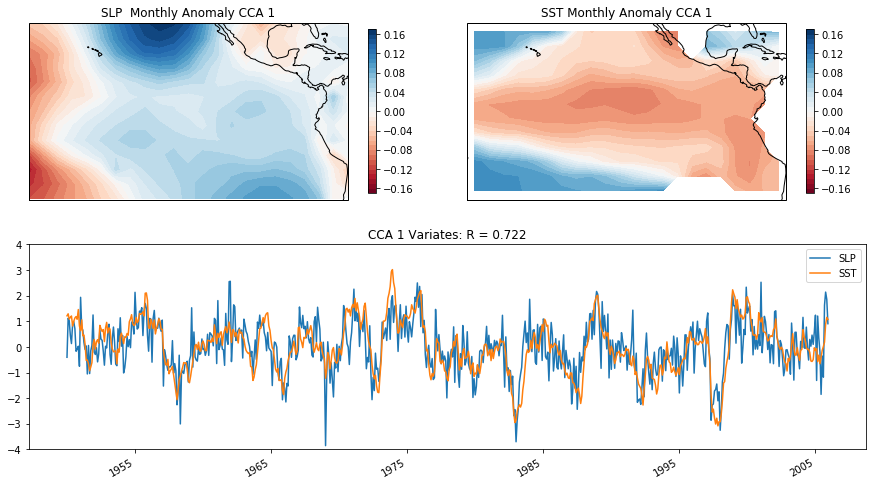

In [7]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.1, hspace=0.15)
levels = np.arange(-0.17, 0.171, 0.01)

# plot SLP  Monthly Anomaly CCA 1
ax1 = fig.add_subplot(gs[0,0],  projection=ccrs.PlateCarree())
x1, y1 = np.meshgrid(lon_slp, lat_slp)
cs = ax1.contourf(x1, y1, A,
                        levels=levels,
                        transform=ccrs.PlateCarree(),
                        cmap='RdBu')
    
cb=fig.colorbar(cs, ax=ax1, shrink=0.8, aspect=20)    
ax1.coastlines()
ax1.set_global()
ax1.set_extent([-180, -70, -19, 19])
ax1.set_title('SLP  Monthly Anomaly CCA 1')

# plot SST Monthly Anomaly CCA 1
ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
x2, y2 = np.meshgrid(lon_sst, lat_sst)
cs2 = ax2.contourf(x2, y2, BB,
                        levels=levels, 
                        transform=ccrs.PlateCarree(),
                        cmap='RdBu')
    
cb2=fig.colorbar(cs2, ax=ax2, shrink=0.8, aspect=20)
ax2.coastlines()
ax2.set_global()
ax2.set_extent([-180, -70, -19, 19])
ax2.set_title('SST Monthly Anomaly CCA 1')

# plot CCA 1 Variates
ax3 = fig.add_subplot(gs[1,:]) 
ax3.plot(dates, slp_c[:,0], label='SLP')
ax3.plot(dates, sst_c[:,0], label='SST')
r = np.corrcoef(slp_c[:,0], sst_c[:,0])[0, 1]
ax3.set_title('CCA 1 Variates: R = ' + str(round(r,3)))
ax3.legend()
ax3.set_ylim([-4,4])

ax3.format_xdata = mdates.DateFormatter('%Y')
#ax3.grid(True)
fig.autofmt_xdate()

## 5. Summary

The above figure shows the first CCA mode calculated between the monthly anomaly fields of Sea Surface Pressure (SLP) and Sea Surface Temperature (SST) for the region of the equatorial Pacific. Mode 1 shows the strong large scale coupling between SLP and SST anomalies (e.g. areas with positive CCA values in SLP appear to coincide with negative SST). This is what we would expect of the El Niño Southern Oscillation (ENSO) - High SLP anomalies in the western Pacific is typical of the warm El Niño phase, which results in warmer SST anomalies throughout the equatorial Pacific. The opposite La Niña phase results from low SLP in the western Pacific.

However, it is worth noting that the aim in standard CCA is to find the linear relationship between the two variables x and y. Therefore, the method fails if the relationship is non-linear. This also is a similar issue for the linear PCA method used as a preprocessing step for CCA. Another disadvantage of the standard CCA is that it is very sensitive to outliers, as it is based on the correlation coefficient. To overcome these limitations, som Nonlinear canonical correlation analysis (NLCCA) methods have been proposed recently. For example, Hsieh (2000, 2001) introduced an NN approach to improve the standard CCA. In an attempt to increase the flexibility of CCA, Kernel CCA can be used to map the data into a high-dimensional space before performing CCA (known as the kernel trick). If the kernel function is nonlinear, kernel CCA can be used to capture nonlinear relationships in the data (Hardoon et al., 2004). 

Deep Canonical Correlation Analysis (DCCA) was proposed by Andrew et al.(2013), which is a method to learn complex nonlinear transformations of two views of data such that the resulting representations are highly linearly correlated. Parameters of both transformations are jointly learned to maximize the (regularized) total correlation. It can be viewed as a nonlinear extension of the linear method canonical correlation analysis (CCA). 

## References

Allan, R., and T. Ansell, 2006: A New Globally Complete Monthly Historical Gridded Mean Sea Level Pressure Dataset (HadSLP2): 1850-2004. J. Climate, 19, 5816-5842.

Kaplan, A., M. Cane, Y. Kushnir, A. Clement, M. Blumenthal, and B. Rajagopalan, Analyses of global sea surface temperature 1856-1991, Journal of Geophysical Research, 103, 18,567-18,589, 1998

Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011)

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Hoyer, S. & Hamman, J., (2017). xarray: N-D labeled Arrays and Datasets in Python. Journal of Open Research Software. 5(1), p.10. DOI: http://doi.org/10.5334/jors.148

Barnett, T. P., and R. Preisendorfer, 1987: Origins and levels of monthly and seasonal forecast skill for United States surface air temperatures determined by canonical correlation analysis. Mon. Wea. Rev., 115, 1825–1850

Harold Hotelling. Relations between two sets of variates. Biometrika, 28(3/4):321–377, 1936.

David R Hardoon, Sandor Szedmak, and John Shawe-Taylor. Canonical correlation analysis: an overview with application to learning methods. Neural computation, 16(12):2639–2664, December 2004. ISSN 0899-7667. doi: 10.1162/0899766042321814. URL http://www.ncbi.nlm.nih.gov/pubmed/15516276.

Hsieh, W. W., 2000: Nonlinear canonical correlation analysis by neural networks. Neural Networks, 13, 1095–1105

Hsieh, W. W. (2001), Nonlinear canonical correlation analysis of the tropical Pacific climate variability using a neural network approach, J. Clim., 14, 2528–2539.

G. Andrew, R. Arora, J. Bilmes, and K. Livescu. Deep canonical correlation analysis. In ICML, 2013